# 뉴스 카테고리 다중분류 [프로젝트]
## 프로젝트: Vocabulary Size를 변경해서 시도해보기

In [10]:
from tensorflow.keras.datasets import reuters
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import keras.backend as K

## 준비

### 모델 준비

In [11]:
def train_model(xtrain, ytrain, xtest, ytest):
    nb = MultinomialNB() # 나이브 베이즈 분류기
    cb = ComplementNB() # 컴플리먼트 나이브 베이즈 분류기
    lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000) # 로지스틱 회귀
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False) # 선형 서포트 벡터 머신
    tree = DecisionTreeClassifier(max_depth=10, random_state=0) # 결정 트리
    forest = RandomForestClassifier(n_estimators=5, random_state=0) # 랜덤 포레스트
    grbt = GradientBoostingClassifier(random_state=0) # 그래디언트 부스팅 트리
    voting_classifier = VotingClassifier(estimators=[ # 보팅
            ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft', n_jobs=-1)

    model_list = [nb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]

    for model in model_list:
        model.fit(xtrain, ytrain)
        pred = model.predict(xtest)
        print(f'{model} 모델 정확도: {accuracy_score(ytest, pred)}, f1-score: {f1_score(ytest, pred, average="weighted")}')

### 데이터 복원

In [12]:
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = { index + 3 : word for word, index in word_index.items()
                }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

def decode_data(x_train, x_test):
    #train 데이터 복원
    decoded_train = []
    for i in range(len(x_train)):
        tr = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(tr)
    x_train = decoded_train

    # test 데이터 복원
    decoded_test = []
    for i in range(len(x_test)):
        te = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(te)
    x_test = decoded_test

    return x_train, x_test

### 벡터화

In [13]:
def vector(x_train, x_test):
    dtmvector = CountVectorizer()  # DTM
    tfidf_transformer = TfidfTransformer()  # TF-IDF

    # train data
    x_train_dtm = dtmvector.fit_transform(x_train)
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print(x_train_dtm.shape)
    print(tfidfv.shape)

    # test data
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

    return tfidfv, tfidfv_test

## 1. 모든 단어 사용

### 데이터 로드

In [47]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [48]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 2

In [49]:
print(y_train[0])
print(y_test[0])

3
3


In [50]:
num_classes = max(y_train) + 1
print('클래스의 수: ', num_classes)

클래스의 수:  46


### 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


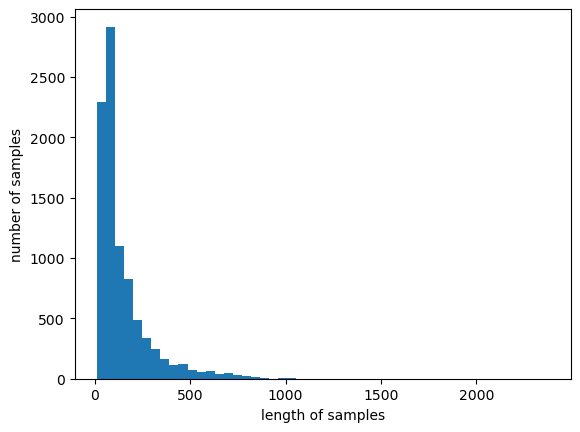

In [51]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

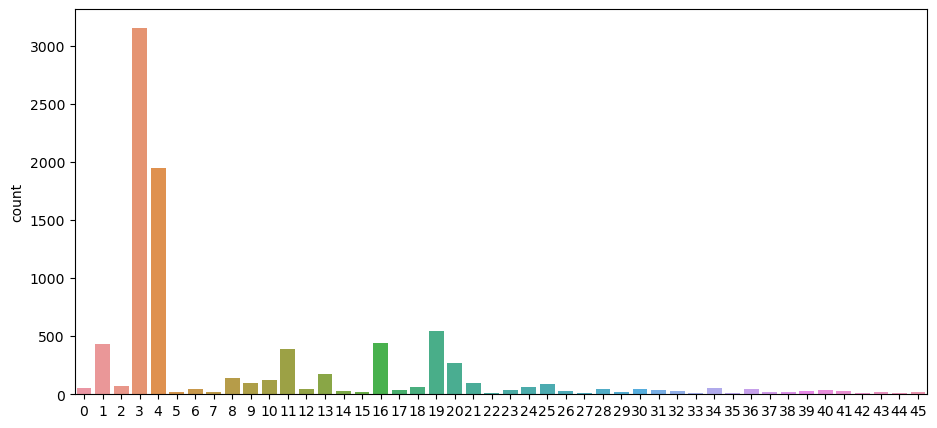

In [52]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [53]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 데이터 복원

In [54]:
x_train, x_test = decode_data(x_train, x_test)

In [55]:
print(x_train[0])
print('\n')
print(x_test[0])

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the e

### 벡터화

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [57]:
tfidfv, tfidfv_test = vector(x_train, x_test)

(8982, 26506)
(8982, 26506)


### 모델 학습

In [60]:
train_model(tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB() 모델 정확도: 0.5997328584149599, f1-score: 0.5045670886188423
ComplementNB() 모델 정확도: 0.7649154051647373, f1-score: 0.7346534179503126
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8165627782724845, f1-score: 0.8111155027654025
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.786286731967943, f1-score: 0.782191053529955
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6211041852181657, f1-score: 0.5769283128518846
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6544968833481746, f1-score: 0.6225909375608356
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7707034728406055, f1-score: 0.7647864978004083
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8156723063223509, 

## 2. 빈도수 상위 5,000개의 단어만 사용

In [71]:
K.clear_session()

In [72]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [73]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [74]:
x_train, x_test = decode_data(x_train, x_test)

In [75]:
tfidfv, tfidfv_test = vector(x_train, x_test)

(8982, 4867)
(8982, 4867)


In [76]:
train_model(tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB() 모델 정확도: 0.6731967943009796, f1-score: 0.6012501291711391
ComplementNB() 모델 정확도: 0.7707034728406055, f1-score: 0.7458990404916549
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8036509349955476, f1-score: 0.7985473379456164
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7756010685663401, f1-score: 0.7722155920025688
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6179875333926982, f1-score: 0.5729970881280324
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6999109528049866, f1-score: 0.6756757143753163
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7684772929652716, f1-score: 0.7671578930104616
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8103294746215495

## 3. 직접 단어 개수를 설정해서 사용

In [83]:
K.clear_session()

### 3-1. num_words = 10000

In [78]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2) # data load

In [79]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [80]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [81]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 9670)
(8982, 9670)


In [82]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6567230632235085, f1-score: 0.5764467518778252
ComplementNB() 모델 정확도: 0.7707034728406055, f1-score: 0.7456682614453047
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8098842386464826, f1-score: 0.8049045165492067
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7867319679430098, f1-score: 0.7828355760670743
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6202137132680321, f1-score: 0.5776398779280149
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.674087266251113, f1-score: 0.6429484177284822
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7693677649154052, f1-score: 0.7657116922370131
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8156723063223509,

### 3-2. num_words = 3000

In [62]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2) # data load

In [63]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 2, 111, 8, 25, 109, 29, 2, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 2, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [64]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [65]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 2919)
(8982, 2919)


In [66]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6874443455031166, f1-score: 0.6266168450864102
ComplementNB() 모델 정확도: 0.7644701691896705, f1-score: 0.7369718160654114
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.7880676758682101, f1-score: 0.783784564292078
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7586821015138023, f1-score: 0.7559792625098161
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6260017809439002, f1-score: 0.580006731123168
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.684772929652716, f1-score: 0.6580696173126419
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.776046304541407, f1-score: 0.7724238105009631
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.802760463045414, f1-

### 3-3. num_words = 15000

In [84]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2) # data load

In [85]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [86]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [87]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 14227)
(8982, 14227)


In [88]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6331255565449688, f1-score: 0.5498212868794679
ComplementNB() 모델 정확도: 0.7720391807658059, f1-score: 0.7448186439256785
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8143365983971504, f1-score: 0.8094584042596985
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.790293855743544, f1-score: 0.7862851650381546
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6188780053428317, f1-score: 0.5751559040653084
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6714158504007124, f1-score: 0.6406930098492383
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7702582368655387, f1-score: 0.7672496737326034
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8147818343722173,

|모델/num_words|all|3000|5000|10000|15000|
|:---:|:---:|:---:|:---:|:---:|:---:|
|나이브 베이즈 분류기|0.600|**0.687**|0.673|0.657|0.633|
|컴플리먼트 나이브 베이즈 분류기|0.765|0.764|0.771|0.771|**0.772**|
|로지스틱 회귀|<span style="color:red">0.817</span>|0.788|0.804|0.810|0.814|
|선형 서포트 벡터 머신|0.788|0.756|0.777|0.785|**0.793**|
|결정 트리|0.621|**0.626**|0.618|0.620|0.619|
|랜덤 포레스트|0.654|0.685|**0.700**|0.674|0.671|
|그래디언트 부스팅 트리|0.771|**0.776**|0.768|0.769|0.770|
|보팅|**0.816**|0.803|0.810|**0.816**|0.815|

## 4. RNN
위 모델들에서 가장 성능이 좋았던 모든 데이터에 대해 LSTM 적용

In [14]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
print(len(x_train), len(x_test))
max_len = max(len(l) for l in np.concatenate((x_train, x_test), axis=0))
print('max_len : ', max_len)

8982 2246
max_len :  2376


In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [16]:
vocab_size = len(index_to_word)
word_vector_dim = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(46, activation='softmax'))

mc = ModelCheckpoint("reuters.h5",monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=100, callbacks=[es, mc], batch_size=64, validation_split=0.3, verbose=1)

Epoch 1/100
99/99 [==============================] - 13s 114ms/step - loss: 2.5418 - accuracy: 0.3552 - val_loss: 2.0485 - val_accuracy: 0.4835
Epoch 2/100
99/99 [==============================] - 11s 113ms/step - loss: 1.9006 - accuracy: 0.4967 - val_loss: 1.8349 - val_accuracy: 0.5124
Epoch 3/100
99/99 [==============================] - 11s 114ms/step - loss: 1.6897 - accuracy: 0.5526 - val_loss: 1.7409 - val_accuracy: 0.5340
Epoch 4/100
99/99 [==============================] - 11s 116ms/step - loss: 1.6117 - accuracy: 0.5783 - val_loss: 1.7038 - val_accuracy: 0.5647
Epoch 5/100
99/99 [==============================] - 12s 118ms/step - loss: 1.3806 - accuracy: 0.6386 - val_loss: 1.5810 - val_accuracy: 0.6093
Epoch 6/100
99/99 [==============================] - 12s 118ms/step - loss: 1.1259 - accuracy: 0.7010 - val_loss: 1.4673 - val_accuracy: 0.6423
Epoch 7/100
99/99 [==============================] - 12s 117ms/step - loss: 0.9348 - accuracy: 0.7528 - val_loss: 1.4850 - val_accuracy:

In [27]:
model = load_model('reuters.h5')
model.evaluate(x_test, y_test)

71/71 [==============================] - 2s 31ms/step - loss: 1.8498 - accuracy: 0.6278


[1.8498387336730957, 0.6277827024459839]

## 5. 결론

### 루브릭

|평가문항|상세기준|
|:---|:---|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?	|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|



### 고찰

<span style="color:blue">같은 모델 중 가장 높은 정확도</span>  
<span style="color:green">같은 num_words 중 가장 높은 정확도</span>  
<span style="color:red">같은 모델과 num_words에서 가장 높은 정확도</span>

|accuracy|all|3000|5000|10000|15000|
|:---:|:---:|:---:|:---:|:---:|:---:|
|나이브 베이즈 분류기|0.600|<span style="color:blue">0.687</span>|0.673|0.657|0.633|
|컴플리먼트 나이브 베이즈 분류기|0.765|0.764|0.771|0.771|<span style="color:blue">0.772</span>|
|로지스틱 회귀|<span style="color:red">0.817</span>|0.788|0.804|0.810|0.814|
|선형 서포트 벡터 머신|0.788|0.756|0.777|0.785|<span style="color:blue">0.793</span>|
|결정 트리|0.621|<span style="color:blue">0.626</span>|0.618|0.620|0.619|
|랜덤 포레스트|0.654|0.685|<span style="color:blue">0.700</span>|0.674|0.671|
|그래디언트 부스팅 트리|0.771|<span style="color:blue">0.776</span>|0.768|0.769|0.770|
|보팅|<span style="color:blue">0.816</span>|<span style="color:green">0.803</span>|<span style="color:green">0.810</span>|<span style="color:red">0.816</span>|<span style="color:green">0.815</span>|

accuracy에서,
- 나이브 베이즈 분류기: 데이터가 적을수록(중요도 높은 단어만 사용했을 경우) 성능이 가장 높았다. 나이브 베이즈 분류기가 베이즈 정리를 바탕으로 한 통계적 분류 기법이기 때문인 것 같다.
- 다른 모델에서는 num_words 개수의 영향을 크게 받지 않은 것으로 보인다.
- 트리 기반 모델은 희소 고차원 데이터(가령, 지금의 텍스트 데이터 같은)에는 적합하지 않아 좋은 성능을 내지 못했다.
- 로지스틱 회귀와 보팅에서 num_words에 관게없이 좋은 성능을 보였다. 
- 가장 좋은 성능을 낸 모델은 로지스틱 회귀 모델이었지만 앙상블 학습의 특성상, 보팅이 다양한 조건에서 유연성을 보여주었다.

<span style="color:blue">같은 모델 중 가장 높은 f1 score</span>  
<span style="color:green">같은 num_words 중 가장 높은 f1 score</span>  
<span style="color:red">같은 모델과 num_words에서 가장 높은 f1 score</span>

|f1-score|all|3000|5000|10000|15000|
|:---:|:---:|:---:|:---:|:---:|:---:|
|나이브 베이즈 분류기|0.505|<span style="color:blue">0.627</span>|0.601|0.576|0.550|
|컴플리먼트 나이브 베이즈 분류기|0.735|0.737|<span style="color:blue">0.746</span>|<span style="color:blue">0.746</span>|0.745|
|로지스틱 회귀|<span style="color:blue">0.811</span>|0.784|0.799|0.805|0.809|
|선형 서포트 벡터 머신|0.782|0.756|0.772|0.783|<span style="color:blue">0.786</span>|
|결정 트리|0.577|<span style="color:blue">0.580</span>|0.573|0.578|0.575|
|랜덤 포레스트|0.623|0.658|<span style="color:blue">0.676</span>|0.643|0.641|
|그래디언트 부스팅 트리|0.765|<span style="color:blue">0.772</span>|0.767|0.766|0.767|
|보팅|<span style="color:green">0.812</span>|<span style="color:green">0.799</span>|<span style="color:green">0.808</span>|<span style="color:red">0.813</span>|<span style="color:red">0.813</span>|

f1 score에서,
- 모든 num_words에서 보팅의 성능이 가장 높았다.
- f1 score에서도 나이브 베이즈 분류기를 제외하면 num_words 개수에 큰 영향을 받지 않았다.
- 전체적으로 accuracy와 f1 score가 비슷한 값을 보였다.
- accuracy에서와 같이 보팅이 다른 조건에서도 비슷한 성능을 보였다.

|모델|모든 데이터|
|:---:|:---:|
|로지스틱 회귀|**0.817**|
|LSTM|0.628|

가장 정확도가 높았던 로지스틱 회귀와 LSTM 모델을 비교했을 때, 로지스틱 회귀의 성능이 더 높았다. LSTM의 성능이 생각보다 낮았는데, 사전 임베딩 사용, 정규화, BoW 방식으로 변경하는 등의 방법으로 성능을 개선시킬 수 있을 것 같다. 같은 조건 하에서는 일반적인 로지스틱 회귀가 더 좋은 방법인 것 같다.

### 회고

|KPT|내용|
|:---|:---|
|keep|다양한 조건에서 모델의 정확도를 알아보았고, 비교하였다.|
|problem|모델 특성에 기반한 깊이 있는 원인 분석이 부족했던 것 같다.|
|try|각 모델에 대해 더 알아보기|